In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
import pymc3 as pm
import arviz as az
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [76]:
# customer churn dataset
df = pd.read_csv(r'C:\Users\vidha\Desktop\IISc\CP218 - Theory and applications of bayesian learning\Project2\Datasets\Iranian-Churn-Dataset-Data-Set\Customer Churn.csv')
print(df)

      Call Failure  Complains  Subscription Length  Charge Amount  \
0                8          0                   38              0   
1                0          0                   39              0   
2               10          0                   37              0   
3               10          0                   38              0   
4                3          0                   38              0   
...            ...        ...                  ...            ...   
3145            21          0                   19              2   
3146            17          0                   17              1   
3147            13          0                   18              4   
3148             7          0                   11              2   
3149             8          1                   11              2   

      Seconds of Use  Frequency of use  Frequency of SMS  \
0               4370                71                 5   
1                318                 5             

In [77]:
# customer churn datset
df.corr()['Customer Value']

Call Failure               0.121225
Complains                 -0.132895
Subscription Length        0.109565
Charge Amount              0.169428
Seconds of Use             0.415087
Frequency of use           0.401572
Frequency of SMS           0.924877
Distinct Called Numbers    0.284807
Age Group                 -0.183481
Tariff Plan                0.252298
Status                    -0.412990
Age                       -0.220362
Customer Value             1.000000
Churn                     -0.289144
Name: Customer Value, dtype: float64

In [78]:
# customer churn dataset
df_selected = df[['Call Failure', 'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Customer Value']]

In [79]:
# customer churn dataset
df_selected.corr()['Customer Value']

Call Failure               0.121225
Subscription Length        0.109565
Charge Amount              0.169428
Seconds of Use             0.415087
Frequency of use           0.401572
Frequency of SMS           0.924877
Distinct Called Numbers    0.284807
Customer Value             1.000000
Name: Customer Value, dtype: float64

In [80]:
df_selected.head()

,Call Failure,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Customer Value
0,8,38,0,4370,71,5,17,197.640
1,0,39,0,318,5,7,4,46.035
2,10,37,0,2453,60,359,24,1536.520
3,10,38,0,4198,66,1,35,240.020
4,3,38,0,2393,58,2,33,145.805


In [81]:
columns = list(df_selected.columns)

In [82]:
# customer churn dataset
corr_list = list(abs(df_selected.corr()['Customer Value']))[0:-1]

In [83]:
print(corr_list)

[0.12122547807813197, 0.10956475601133772, 0.16942770681800293, 0.4150872449805451, 0.4015724637117215, 0.9248774260038474, 0.2848074264548181]


In [84]:
array_selected = df_selected.values
print(np.shape(array_selected))

(3150, 8)


In [85]:
# customer churn dataset
input_idx = [0,1,2,3,4,5,6]
output_idx = [7]

In [86]:
X = array_selected[:,input_idx]
y = array_selected[:,output_idx].astype('int')

In [87]:
def choose_features(num_of_features_choosen):
    temp1 = list(np.argsort(corr_list)[::-1][:num_best_features])
    temp2 = [input_idx[val] for val in temp1]
    choosen_features = [columns[val] for val in temp2]
    return choosen_features

In [95]:
num_best_features = 7
choosen_features = choose_features(num_best_features)
print("\nchoosen features :\n",choosen_features)
input_features = np.array(df_selected[choosen_features]).reshape(-1,len(choosen_features))
output_features = np.array(df_selected[['Customer Value']]).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(input_features, output_features, test_size = 0.25)

scaler = MinMaxScaler()
# transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)


choosen features :
 ['Frequency of SMS', 'Seconds of Use', 'Frequency of use', 'Distinct Called Numbers', 'Charge Amount', 'Call Failure', 'Subscription Length']


[0.52, 0.16, 0.13, 0.1, 0.05, 0.04, 0.01]


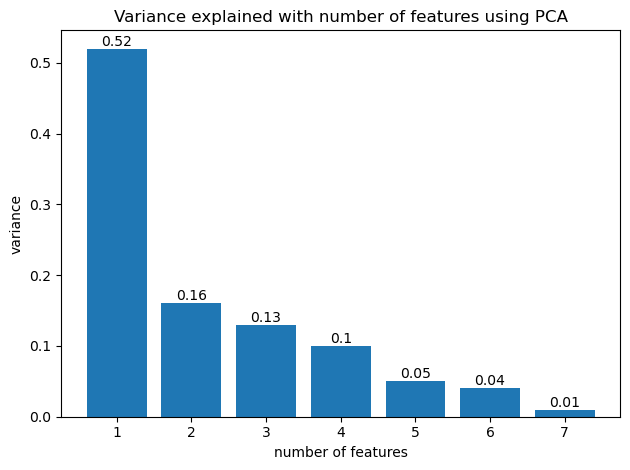

In [96]:
pca = PCA()
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance=[round(elem,2) for elem in explained_variance]
print(explained_variance)
x_bar = [i for i in range(1,len(explained_variance)+1)]
fig = plt.bar(x =x_bar, height=explained_variance)
plt.bar_label(labels=explained_variance,container=fig)

plt.title('Variance explained with number of features using PCA')
plt.xlabel("number of features")
plt.ylabel("variance")
plt.tight_layout()

In [97]:
# num_best_features = 4
# pca = PCA(n_components=num_best_features)
# X_train_scaled = pca.fit_transform(X_train_scaled)
# X_test_scaled = pca.transform(X_test_scaled)

In [98]:
n = 1
poly = PolynomialFeatures(degree = n, interaction_only=False, include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_test_scaled_poly = poly.fit_transform(X_test_scaled)

In [99]:
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(2362, 7)
(788, 7)


In [100]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=100)
#     beta = pm.Normal('beta', mu=0, sigma=100, shape=num_best_features)
    beta = pm.Normal('beta', mu=0, sigma=100, shape=np.shape(X_train_scaled_poly)[1])
    sigma = pm.HalfNormal('sigma', sigma=100)

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled_poly,beta)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_train_scaled.flatten())

In [101]:
with basic_model:
    # draw 5000 posterior samples
    trace = pm.sample(5000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 75 seconds.


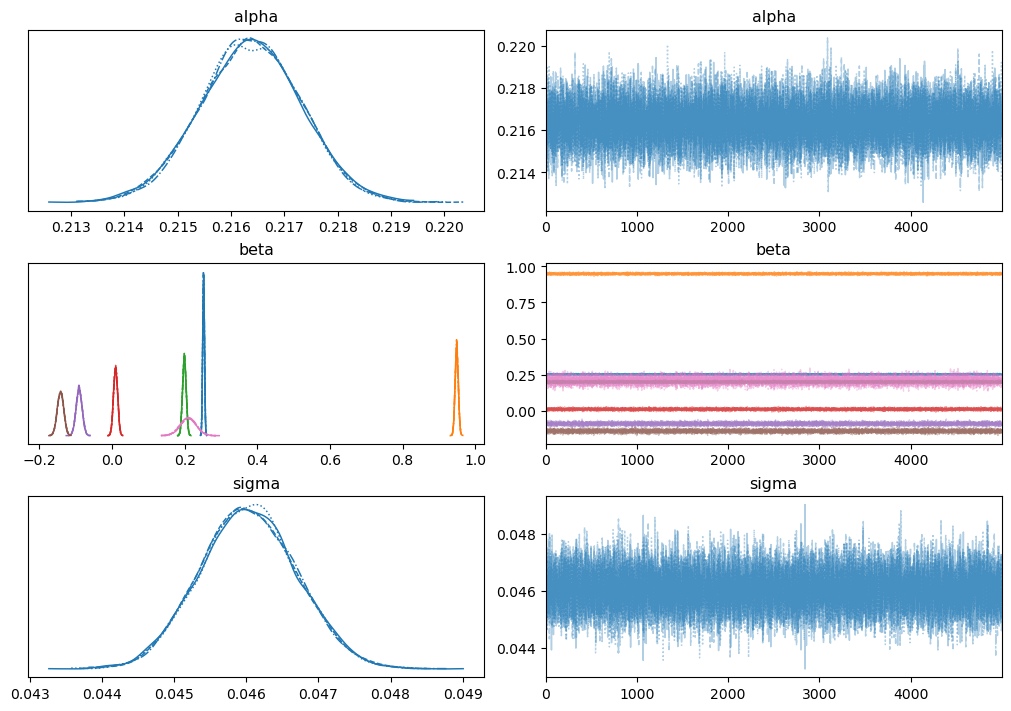

In [102]:
axes = az.plot_trace(trace, figsize=(10, 7))

In [103]:
fig = axes.ravel()[0].figure
fig.savefig('plots\MCMC_regression_trace_plot.jpg',dpi=150)

In [104]:
pm.summary(trace).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.22,0.00,0.22,0.22,0.0,0.0,31248.0,15476.0,1.0
beta[0],0.25,0.00,0.25,0.26,0.0,0.0,30369.0,16107.0,1.0
beta[1],0.95,0.00,0.94,0.96,0.0,0.0,32253.0,16488.0,1.0
beta[2],0.20,0.00,0.19,0.21,0.0,0.0,31502.0,15514.0,1.0
beta[3],0.01,0.01,-0.00,0.02,0.0,0.0,25548.0,15660.0,1.0
beta[4],-0.09,0.01,-0.11,-0.08,0.0,0.0,28462.0,16367.0,1.0
beta[5],-0.14,0.01,-0.16,-0.13,0.0,0.0,28896.0,16814.0,1.0
beta[6],0.21,0.02,0.17,0.25,0.0,0.0,32069.0,16383.0,1.0
sigma,0.05,0.00,0.04,0.05,0.0,0.0,30194.0,16001.0,1.0


In [105]:
MAP_parameters = pm.find_MAP(model=basic_model)

In [106]:
print(MAP_parameters)

{'alpha': array(0.21637394), 'beta': array([ 0.25198578,  0.94897813,  0.19904886,  0.00963676, -0.09073776,
       -0.14201574,  0.20979593]), 'sigma_log__': array(-3.08071664), 'sigma': array(0.04592633)}


In [107]:
intercept = []
coeff = []
sigma = []
for key,val in MAP_parameters.items():
    if key=='alpha':
        intercept.append(val.tolist())
    if key=='beta':
        coeff = val.tolist()
    if key=='sigma':
        sigma.append(val.tolist())

In [108]:
coeff = np.array(coeff).reshape(-1,1)
y_pred = intercept[0] + np.dot(X_test_scaled_poly,coeff)

In [109]:
se = []
for i in range(np.size(y_pred)):
    error = (y_pred[i][0] - y_test_scaled[i][0])**2
    se.append(error)

print("rmse : ", np.sqrt(sum(se)/np.size(y_pred)))

y_pred = scaler.inverse_transform(y_pred)
actual_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f"scaled rmse with degree {n} is : {actual_rmse}")

rmse :  0.04551662449758176
scaled rmse with degree 1 is : 97.82797070016254


In [110]:
u = sum(se)
tss = []

for i in range(np.size(y_test_scaled)):
    tss.append((y_test_scaled[i][0] - y_test_scaled.mean())**2)

v = sum(tss)

R2_score = 1-(u/v)
print(R2_score)

0.9637420672779741
